## Import packages

In [1]:
# No warnings
import warnings
warnings.filterwarnings('ignore')

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

pd.set_option('display.max_columns', 100) 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning tools from sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

import xgboost as xgb

# Plot styling
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 10 , 6

## Input Data

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
train_df = shuffle(train_df)
combine = [train_df, test_df]
# combine is only a pointer to the objects and used to ensure whatever preprocessing is done


# Exploratory Data Anlysis (EDA)
We will analyze the data to see how we can work with it and what makes sense.

In [4]:
print(train_df.columns.values) 

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [5]:
# preview the data
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S
804,805,1,3,"Hedman, Mr. Oskar Arvid",male,27.0,0,0,347089,6.9750,NaN,S
552,553,0,3,"O'Brien, Mr. Timothy",male,NaN,0,0,330979,7.8292,NaN,Q
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S


In [6]:
# General data statistics
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# Data Frame information (null, data type etc)
train_df.info()
# exist great number of null in age collumn

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 815 to 701
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


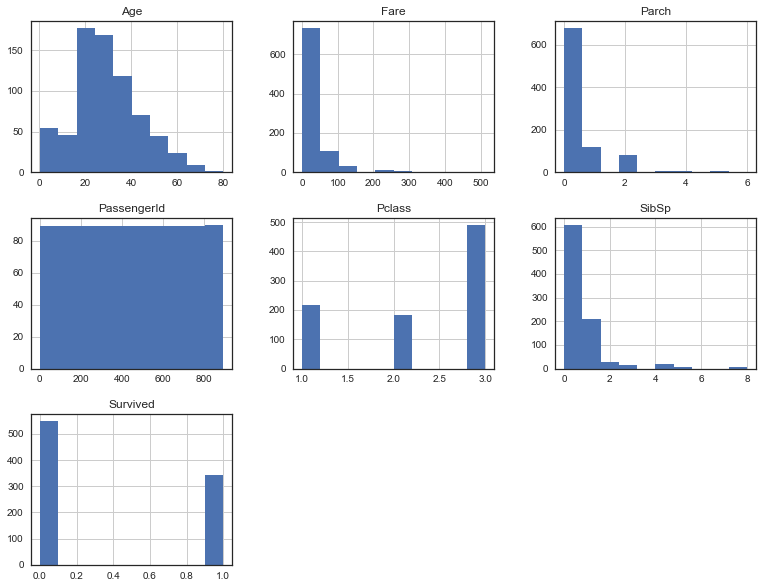

In [8]:
train_df.hist(figsize=(13,10))
plt.show()

In [9]:
# Balanced data set?
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [10]:
_

0    549
1    342
Name: Survived, dtype: int64

In [11]:
_[0]/(sum(_)) #base line for prediction accuracy

0.6161616161616161

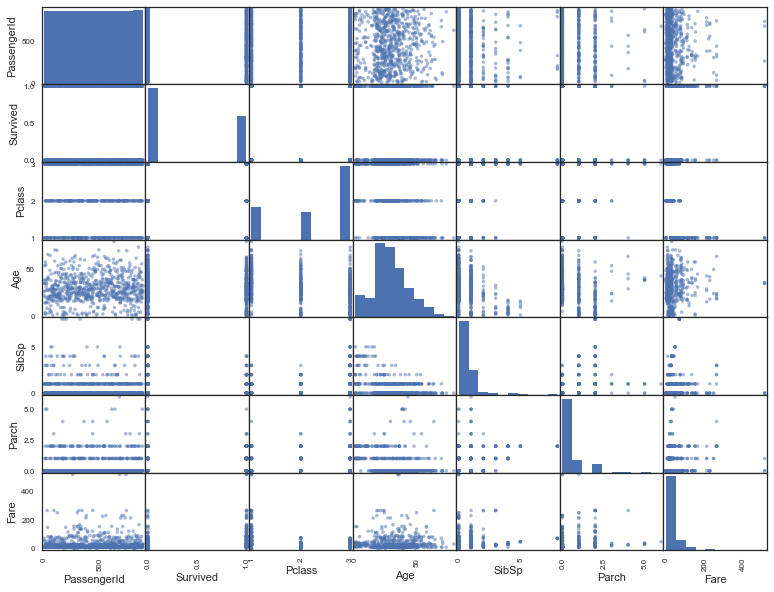

In [12]:
pd.tools.plotting.scatter_matrix(train_df,figsize=(13,10));

## Comment on the Data

> `PassengerId` is a random number (incrementing index) and thus does not contain any valuable information. 
>
>`Survived, Passenger Class, Age Siblings Spouses, Parents Children` and `Fare` are numerical values -- so we don't need to transform them, but we might want to group them (i.e. create categorical variables). 
>
>`Sex, Embarked` are categorical features that we need to map to integer values. `Name, Ticket` and `Cabin` might also contain valuable information.

# Preprocessing Data

In [13]:
# check dimensions of the train and test datasets
print("Shapes Before: (train) (test) = ", \
      train_df.shape, test_df.shape)

Shapes Before: (train) (test) =  (891, 12) (418, 11)


In [14]:
# Drop columns 'Ticket', 'Cabin', need to do it for both test
# and training

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("Shapes After: (train) (test) =", train_df.shape, test_df.shape)

Shapes After: (train) (test) = (891, 10) (418, 9)


In [15]:
# Check if there are null values in the datasets

print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


## Hypotheses

## 1: The Title of the person is a feature that can predict survival

In [16]:
# List example titles in Name column
train_df.Name[:5]

815           Fry, Mr. Richard
804    Hedman, Mr. Oskar Arvid
552       O'Brien, Mr. Timothy
128          Peter, Miss. Anna
692               Lam, Mr. Ali
Name: Name, dtype: object

In [17]:
# from the Name column we will extract title of each passenger
# and save that in a column in the dataset called 'Title'

# Create new column called title

for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.',\
                                                expand=False)


In [18]:
combine[0]['Title'].head()

815      Mr
804      Mr
552      Mr
128    Miss
692      Mr
Name: Title, dtype: object

In [19]:
# To check that our titles makes sense (by comparing to sex)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [20]:
# same for test set
pd.crosstab(test_df['Title'], test_df['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [21]:
# We see common titles like Miss, Mrs, Mr, Master are dominant, we will
# correct some Titles to standard forms and replace the rarest titles 
# with single name 'Rare'

for dataset in combine:
    dataset['Title'] = dataset['Title'].\
                  replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',\
                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') #Mademoiselle
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') #Madame

In [22]:
# plot the survival chance for each title, using groupby with mean aggregation

train_df[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


In [23]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,0.0000,S,Mr
804,805,1,3,"Hedman, Mr. Oskar Arvid",male,27.0,0,0,6.9750,S,Mr
552,553,0,3,"O'Brien, Mr. Timothy",male,NaN,0,0,7.8292,Q,Mr
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,22.3583,C,Miss
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,56.4958,S,Mr


In [24]:
# Title dummy mapping
# Map titles to binary dummy columns
for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Title)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,0.0000,S,Mr,0,0,1,0,0
804,805,1,3,"Hedman, Mr. Oskar Arvid",male,27.0,0,0,6.9750,S,Mr,0,0,1,0,0
552,553,0,3,"O'Brien, Mr. Timothy",male,NaN,0,0,7.8292,Q,Mr,0,0,1,0,0
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,22.3583,C,Miss,0,1,0,0,0
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,56.4958,S,Mr,0,0,1,0,0


In [25]:
train_df = train_df.drop(['PassengerId','Name', 'Title'], axis=1)
test_df = test_df.drop(['Name', 'Title'], axis=1)
combine = [train_df, test_df]

In [26]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
815,0,1,male,NaN,0,0,0.0000,S,0,0,1,0,0
804,1,3,male,27.0,0,0,6.9750,S,0,0,1,0,0
552,0,3,male,NaN,0,0,7.8292,Q,0,0,1,0,0
128,1,3,female,NaN,1,1,22.3583,C,0,1,0,0,0
692,1,3,male,NaN,0,0,56.4958,S,0,0,1,0,0


### Map Sex column to binary (male = 0, female = 1) categories

In [27]:

for dataset in combine:
    dataset['Sex'] = dataset['Sex']. \
        map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
815,0,1,0,NaN,0,0,0.0000,S,0,0,1,0,0
804,1,3,0,27.0,0,0,6.9750,S,0,0,1,0,0
552,0,3,0,NaN,0,0,7.8292,Q,0,0,1,0,0
128,1,3,1,NaN,1,1,22.3583,C,0,1,0,0,0
692,1,3,0,NaN,0,0,56.4958,S,0,0,1,0,0


## Handle missing values for age
We will now guess values of age based on sex (male / female) 
and socioeconomic class (1st,2nd,3rd) of the passenger.

The row indicates the sex, male = 0, female = 1

More refined estimate than only taking the median / mean etc.

In [28]:
guess_ages = np.zeros((2,3),dtype=int) #initialize
guess_ages

array([[0, 0, 0],
       [0, 0, 0]])

In [29]:
# Fill the NA's for the Age columns
# with "qualified guesses"

for idx,dataset in enumerate(combine):
    if idx==0:
        print('Working on Training Data set\n')
    else:
        print('-'*35)
        print('Working on Test Data set\n')
    
    print('Guess values of age based on sex and pclass of the passenger...')
    for i in range(0, 2):
        for j in range(0,3):
            guess_df = dataset[(dataset['Sex'] == i) \
                        &(dataset['Pclass'] == j+1)]['Age'].dropna()

            # Extract the median age for this group
            # (less sensitive) to outliers
            age_guess = guess_df.median()
          
            # Convert random age float to int
            guess_ages[i,j] = int(age_guess)
    
            
    print('Guess_Age table:\n',guess_ages)
    print ('\nAssigning age values to NAN age values in the dataset...')
    
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) \
                    & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]
                    

    dataset['Age'] = dataset['Age'].astype(int)
    print()
print('Done!')
train_df.head()

Working on Training Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[40 30 25]
 [35 28 21]]

Assigning age values to NAN age values in the dataset...

-----------------------------------
Working on Test Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[42 28 24]
 [41 24 22]]

Assigning age values to NAN age values in the dataset...

Done!


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
815,0,1,0,40,0,0,0.0000,S,0,0,1,0,0
804,1,3,0,27,0,0,6.9750,S,0,0,1,0,0
552,0,3,0,25,0,0,7.8292,Q,0,0,1,0,0
128,1,3,1,21,1,1,22.3583,C,0,1,0,0,0
692,1,3,0,25,0,0,56.4958,S,0,0,1,0,0


In [32]:
# Change Age column to
# map Age ranges (AgeBands) to integer values of categorical type in infant, teenager and adult 
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 6, 'Age'] = 0  
    dataset.loc[(dataset['Age'] > 6) & (dataset['Age'] <= 16), 'Age'] = 1
    dataset.loc[ dataset['Age'] > 16, 'Age']= 2
#train_df.head()

# Note we could just run 
# dataset['Age'] = pd.cut(dataset['Age'], 5,labels=[0,1,2,3,4])
train_df[['Age', 'Survived']].groupby(['Age'], as_index=True).mean().sort_values(by='Survived', ascending=False)

,Survived
Age,
0,0.702128
1,0.415094
8,0.362832


# Create variable for Family Size

How did the number of people the person traveled with impact the chance of survival?

In [34]:
# SibSp = Number of Sibling / Spouses
# Parch = Parents / Children

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    
# Survival chance against FamilySize

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


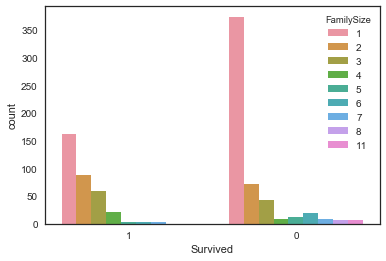

In [35]:
# Plot it, 1 is survived
sns.countplot(x='Survived', hue="FamilySize", data=train_df, order=[1,0]);

In [36]:
# Create binary variable if the person was alone or not

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=True).mean()

,Survived
IsAlone,
0,0.505650
1,0.303538


In [37]:
# We will only use the binary IsAlone feature for further analysis

for df in combine:
    df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1, inplace=True)


train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,IsAlone
815,0,1,0,8,0.0000,S,0,0,1,0,0,1
804,1,3,0,8,6.9750,S,0,0,1,0,0,1
552,0,3,0,8,7.8292,Q,0,0,1,0,0,1
128,1,3,1,8,22.3583,C,0,1,0,0,0,0
692,1,3,0,8,56.4958,S,0,0,1,0,0,1


In [38]:
# We can also create new features based on intuitive combinations
# Here is an example when we say that the age times socioclass is a determinant factor
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(8)

,Age*Class,Age,Pclass
815,8,8,1
804,24,8,3
552,24,8,3
128,24,8,3
692,24,8,3
293,24,8,3
259,16,8,2
673,16,8,2


In [39]:
train_df[['Age*Class', 'Survived']].groupby(['Age*Class'], as_index=True).mean()

,Survived
Age*Class,
0,0.702128
1,1.000000
2,0.714286
3,0.275000
8,0.618357
16,0.417178
24,0.216152


# Port the person embarked from
Let's see how that influences chance of survival

In [40]:
# To replace Nan value in 'Embarked', we will use the mode
# in 'Embaraked'. This will give us the most frequent port 
# the passengers embarked from

freq_port = train_df['Embarked'].dropna().mode()[0]
print('Most frequent port of Embarkation:',freq_port)


Most frequent port of Embarkation: S


In [41]:
# Fill NaN 'Embarked' Values in the datasets
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


In [43]:
# Create categorical dummy variables for Embarked values
for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Embarked)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

    
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
815,0,1,0,8,0.0000,S,0,0,1,0,0,1,8,0,0,1
804,1,3,0,8,6.9750,S,0,0,1,0,0,1,24,0,0,1
552,0,3,0,8,7.8292,Q,0,0,1,0,0,1,24,0,1,0
128,1,3,1,8,22.3583,C,0,1,0,0,0,0,24,1,0,0
692,1,3,0,8,56.4958,S,0,0,1,0,0,1,24,0,0,1


In [44]:
# Drop Embarked
for dataset in combine:
    dataset.drop('Embarked', axis=1, inplace=True)

## Handle continuous values in the Fare column

In [45]:
# Fill the NA values in the Fares column with the median
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,892,3,0,8,7.8292,0,0,1,0,0,1,24,0,1,0
1,893,3,1,8,7.0000,0,0,0,1,0,0,24,0,0,1
2,894,2,0,8,9.6875,0,0,1,0,0,1,16,0,1,0
3,895,3,0,8,8.6625,0,0,1,0,0,1,24,0,0,1
4,896,3,1,8,12.2875,0,0,0,1,0,0,24,0,0,1


In [47]:
for dataset in combine:    
    dataset.loc[ dataset['Fare'] <= 10, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 20), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 20) & (dataset['Fare'] <= 30), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 30, 'Fare']= 3

train_df[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().sort_values(by='Fare', ascending=True)  

,Fare,Survived
0,0.0,0.199405
1,1.0,0.424581
2,2.0,0.443662
3,3.0,0.581197


In [48]:
# Drop FareBand
#train_df = train_df.drop(['FareBand'], axis=1) 
combine = [train_df, test_df]

## Finished

In [49]:
train_df.head(7)
# All features are approximately on the same scale
# no need for feature engineering / normalization

,Survived,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
815,0,1,0,8,0.0,0,0,1,0,0,1,8,0,0,1
804,1,3,0,8,0.0,0,0,1,0,0,1,24,0,0,1
552,0,3,0,8,0.0,0,0,1,0,0,1,24,0,1,0
128,1,3,1,8,2.0,0,1,0,0,0,0,24,1,0,0
692,1,3,0,8,3.0,0,0,1,0,0,1,24,0,0,1
293,0,3,1,8,0.0,0,1,0,0,0,1,24,0,0,1
259,1,2,1,8,2.0,0,0,0,1,0,0,16,0,0,1


In [50]:
test_df.head(7)

,PassengerId,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,892,3,0,8,0.0,0,0,1,0,0,1,24,0,1,0
1,893,3,1,8,0.0,0,0,0,1,0,0,24,0,0,1
2,894,2,0,8,0.0,0,0,1,0,0,1,16,0,1,0
3,895,3,0,8,0.0,0,0,1,0,0,1,24,0,0,1
4,896,3,1,8,1.0,0,0,0,1,0,0,24,0,0,1
5,897,3,0,1,0.0,0,0,1,0,0,1,3,0,0,1
6,898,3,1,8,0.0,0,1,0,0,0,1,24,0,1,0


# Machine Learning Tools
Now we will Model, Predict, and Choose algorithm for conducting the classification
Used different classifiers to model and predict and choose the best model from:
* Logistic Regression
* KNN 
* SVM
* Naive Bayes
* Decision Tree
* Random Forest
* Perceptron
* XGBoost

## Setup Train and Validation Set

In [52]:
X = train_df.drop(['Survived'], axis=1) # Training & Validation data
Y = train_df["Survived"] # Response / Target Variable

# Since we don't have labels for the test data
# this won't be used. It's only for Kaggle Submissions
X_submission  = test_df.drop("PassengerId", axis=1).copy() 

print(X.shape, Y.shape)



(891, 14) (891,)


In [53]:
# Split training and test set so that we test on 20% of the data
# Note that our algorithms will never have seen the validation 
# data during training. This is to evaluate how good our estimators are.

np.random.seed(1337) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2) #改了這邊!!!
X_train = X
Y_train = Y
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(891, 14) (891,)
(179, 14) (179,)


## Scikit-Learn general ML workflow
1. Instantiate model object
2. Fit model to training data
3. Let the model predict output for unseen data
4. Compare predicitons with actual output to form accuracy measure

# Logistic Regression

In [54]:
logreg = LogisticRegression() # instantiate
logreg.fit(X_train, Y_train) # fit
Y_pred = logreg.predict(X_val) # predict
acc_log = sum(Y_pred == Y_val)/len(Y_val)*100
print('Logistic Regression accuracy:', str(round(acc_log,2)),'%')

Logistic Regression accuracy: 82.12 %


In [55]:
# we could also use scikit learn's method score
# that predicts and then compares to validation set labels
acc_log = logreg.score(X_val, Y_val) # evaluate
acc_log

0.8212290502793296

In [56]:
# Support Vector Machines Classifier (non-linear kernel)

svc = SVC()
svc.fit(X_train, Y_train)
acc_svc = svc.score(X_val, Y_val)
acc_svc

0.8268156424581006

In [57]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
acc_knn = knn.score(X_val, Y_val)
acc_knn

0.8268156424581006

In [58]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
acc_perceptron = perceptron.score(X_val, Y_val)
acc_perceptron

0.7988826815642458

In [59]:
# XGBoost, same API as scikit-learn
gradboost = xgb.XGBClassifier(n_estimators=1000)
gradboost.fit(X_train, Y_train)
acc_perceptron = gradboost.score(X_val, Y_val)
acc_perceptron

c:\python362\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8379888268156425

In [60]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, Y_train)
acc_random_forest = random_forest.score(X_val, Y_val)
acc_random_forest

0.8379888268156425

# Importance scores in the random forest model

Training accuracy Random Forest: 0.8585858585858586


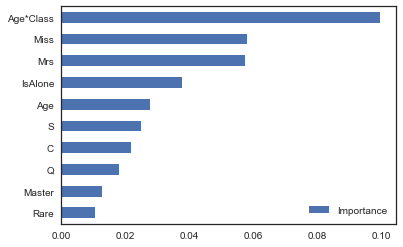

In [61]:
# Look at importnace of features for random forest

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ('Training accuracy Random Forest:',model.score( X , y ))

plot_model_var_imp(random_forest, X_train, Y_train)

# Output the prediction

In [62]:

Y_submission =random_forest.predict(X_submission)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_submission
    })
submission.to_csv('titani66.csv', index=False)